# Bandit simulations - from random uniform policy data

How can we train bandits from data collected from a logging policy, where the logging policy was uniformly distributed.


Evaluate a policy on logged data.
Evaluate the policy on the actual arms used to generate the logged data.
Are the reward estimations unbiased?

In [1]:
import bandits

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_96299/2675420463.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## Simulation setup

We simulate within batches of a fixed size.
Within each batch we predict from a policy to select which arms to select.
We sample from those arms and record the rewards.
At the end of the batch we update the policy with the arms selected and their rewards.

We use the updated policy in the subsequent batch and repeat the process.

## Logging policy

We will generate data from a logging policy.
Our primary output to learn from is the selected arm and the observed reward.
We will use a uniform random policy to collect our logging data.

In [2]:
n_arms = 5
top_k=1
arms = [bandits.BernoulliArm() for _idx in range(n_arms)]
print(arms)

logging_policy = bandits.RandomPolicy(n_arms=n_arms, top_k=top_k)

logging_data = bandits.simulate_batches(
    policy=logging_policy, arms=arms, n_batches=200, batch_size=10, return_regret=False
)

[Bernoulli(0.549), Bernoulli(0.715), Bernoulli(0.603), Bernoulli(0.545), Bernoulli(0.424)]


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 1570.07it/s]


## Off policy evaluation - replay

The bandit problem is trying to learn from incomplete data.
Our logging policy only observed the reward from the arms selected. We do not observe the rewards from the non selected arms.

Off policy evaluation is the technique to evaluate a training policy using data which was logged by a different logging policy.

For example here we have logged data from a uniform random policy.
How do we train and evalutate a Thompson Sampling policy on this data?

One approach is the [replay method](https://arxiv.org/abs/1003.5956).

In [159]:
import tqdm


def replay_logged_data(
    logging_data: bandits.SimulationResults,
    target_policy: bandits.Policy,
    context=None,  #: ContextVectors = None,
    batch_size: int = 10,
    batch_callback=None,  #: callable[Policy, int] = None,
) -> dict:
    """
    Run a simulation with logged data and a target policy.

    arms - not accepted as we dont have knowledge of these
    available_arms comes from the logged data

    Notes:
    Context not stored in logged data.
    If we wanted to add a new feature how would we do that otherwise?
    """

    selected_arms = []
    selected_arms_match = []
    selection_propensities = []
    reward_estimates = []
    rewards = []

    n_batches = int(np.ceil(len(logging_data.selected_arms) / batch_size))

    for _batch_id in tqdm.trange(n_batches):
        _batch_idx = (_batch_id * batch_size, (_batch_id + 1) * batch_size)

        # find desired arm for each round
        (
            _selected_arms,
            _selection_propensities,
            _reward_estimates,
        ) = target_policy.predict(
            arms=logging_data.available_arms[_batch_idx[0] : _batch_idx[1]],
            context=context[_batch_idx[0] : _batch_idx[1]]
            if context is not None
            else None,
        )

        # get reward if logging data has support
        # [TODO] fix for top_k
        _selected_arms_match = np.array(_selected_arms) == np.array(
            logging_data.selected_arms[_batch_idx[0] : _batch_idx[1]]
        )
        _rewards = np.array(logging_data.rewards[_batch_idx[0] : _batch_idx[1]]).astype(
            np.float
        )
        _rewards[np.invert(_selected_arms_match)] = np.nan  # None

        _rewards = _rewards.tolist()
        _selected_arms_match = (1 * _selected_arms_match).tolist()

        # retrain policy with all batches up to know
        # data available = context and observed rewards where rewards not nan

        if context is not None:
            _batch_context_match = context[_batch_idx[0] : _batch_idx[1]][
                _selected_arms_match
            ]
            _selected_context = []
            for _match in _selected_arms_match:
                if _match:
                    _selected_context.append(
                        [
                            _batch_context_match[_round][_idx]
                            for _idx in _selected_arms[_round]
                        ]
                    )
        else:
            _selected_context = None

        target_policy.update(
            arms=[
                _arm
                for _arm, _match in zip(_selected_arms, _selected_arms_match)
                if _match == [1]
            ],
            context=_selected_context,
            rewards=[_reward for _reward, _match in zip(_rewards, _selected_arms_match) if _match==[1]],
        )

        selected_arms += _selected_arms
        selected_arms_match += _selected_arms_match
        # selection_propensities += _selection_propensities
        reward_estimates += _reward_estimates
        rewards += _rewards
        # regret.append(_regret)

    return {
        "selected_arms": selected_arms,
        "selected_arms_match": selected_arms_match,
        "selection_propensities": selection_propensities,
        "reward_estimates": reward_estimates,
        "rewards": rewards,
    }


In [164]:
import tqdm
target_policy = bandits.ThompsonSamplingBeta(n_arms=n_arms, top_k=1)
simulation_results = replay_logged_data(
    logging_data=logging_data,
    target_policy=target_policy,
    context=None,
    batch_size = 10,
    batch_callback = None,
)
simulation_results

  0%|          | 0/200 [00:00<?, ?it/s]/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_96299/3297113672.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float
100%|██████████| 200/200 [00:00<00:00, 211.07it/s]


{'selected_arms': [[1],
  [1],
  [0],
  [0],
  [2],
  [4],
  [0],
  [0],
  [2],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [0],
  [2],
  [2],
  [4],
  [0],
  [2],
  [4],
  [3],
  [1],
  [3],
  [1],
  [1],
  [1],
  [1],
  [1],
  [4],
  [3],
  [1],
  [1],
  [3],
  [3],
  [4],
  [4],
  [4],
  [0],
  [3],
  [0],
  [1],
  [1],
  [1],
  [1],
  [3],
  [1],
  [1],
  [1],
  [3],
  [3],
  [1],
  [1],
  [3],
  [1],
  [1],
  [3],
  [1],
  [1],
  [1],
  [1],
  [1],
  [1],
  [1],
  [1],
  [1],
  [3],
  [0],
  [3],
  [3],
  [1],
  [1],
  [4],
  [1],
  [3],
  [3],
  [0],
  [1],
  [1],
  [1],
  [1],
  [1],
  [1],
  [1],
  [1],
  [2],
  [1],
  [1],
  [1],
  [1],
  [2],
  [1],
  [1],
  [1],
  [1],
  [1],
  [3],
  [2],
  [2],
  [4],
  [1],
  [1],
  [1],
  [1],
  [1],
  [3],
  [1],
  [1],
  [1],
  [1],
  [2],
  [1],
  [4],
  [1],
  [1],
  [4],
  [3],
  [1],
  [2],
  [1],
  [1],
  [1],
  [1],
  [1],
  [2],
  [1],
  [1],
  [4],
  [1],
  [1],
  [1],
  [1],
  [1],
  [4],
  [1],
  [0],
  [1],
  [1],
  [2],
  [

[Bernoulli(0.549), Bernoulli(0.715), Bernoulli(0.603), Bernoulli(0.545), Bernoulli(0.424)]


Beta([ 12 238   5  15   7], [ 9 91  8 12  9])

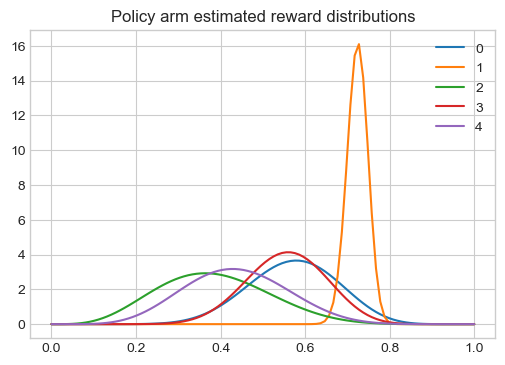

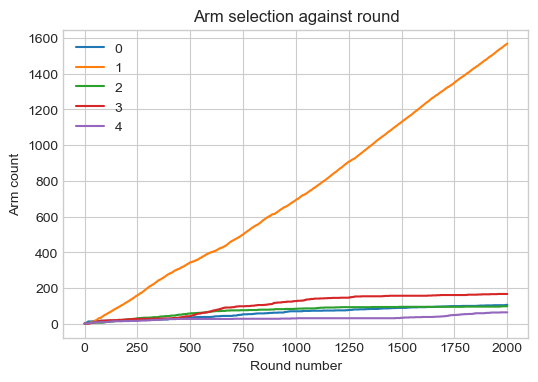

In [165]:
print(arms)
display(target_policy)

fig = target_policy.plot_pdf()
fig.axes[0].set_title("Policy arm estimated reward distributions")

ax = bandits.plot_arm_selection(selected_arms=simulation_results["selected_arms"])


When we have a single arm that the target policy selects as a winner, we want to select it most of the time.
From a uniform random logging policy we would expect to observe its associated reward $1/n_{arms}$.
We can confirm this by checking the average support:

In [168]:
np.array(simulation_results["selected_arms_match"]).mean()

0.198

## Importance weighting

In [ ]:
target_policy = bandits.ThompsonSamplingBeta(n_arms=n_arms, top_k=1)
print(target_policy)

simulation_results = bandits.simulate_batches(
    policy=target_policy, arms=arms, n_batches=20, batch_size=10, return_regret=False
)
display(target_policy)

fig = target_policy.plot_pdf()
fig.axes[0].set_title("Policy arm estimated reward distributions")

ax = bandits.plot_arm_selection(selected_arms=simulation_results["selected_arms"])


[Bernoulli(0.751), Bernoulli(0.407), Bernoulli(0.180), Bernoulli(0.453), Bernoulli(0.649), Bernoulli(0.878), Bernoulli(0.154), Bernoulli(0.277), Bernoulli(0.881), Bernoulli(0.428)]
scaling reward_probs


100%|██████████| 100/100 [00:00<00:00, 1523.53it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_6324/398755801.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_sel.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_6324/398755801.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_rew.show()


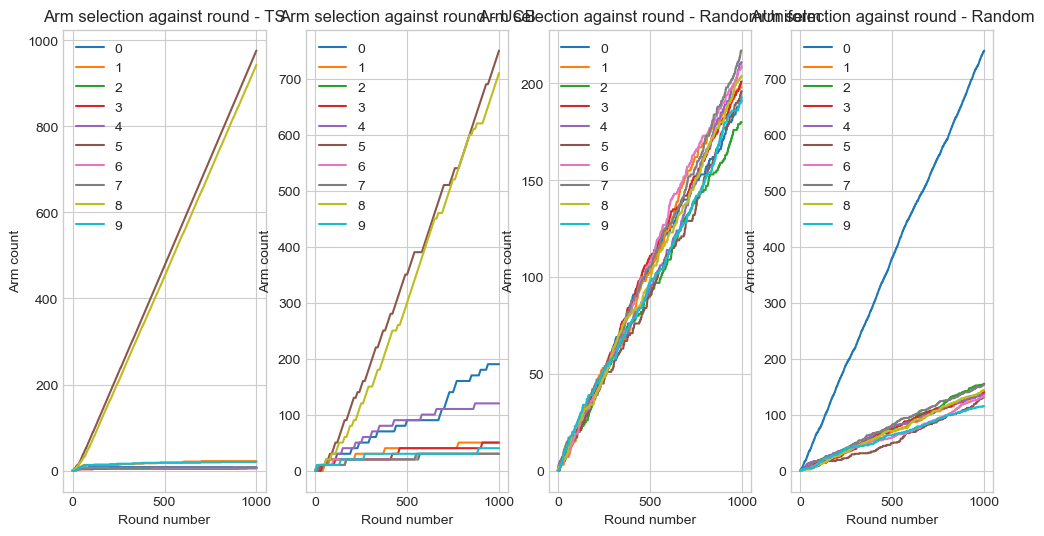

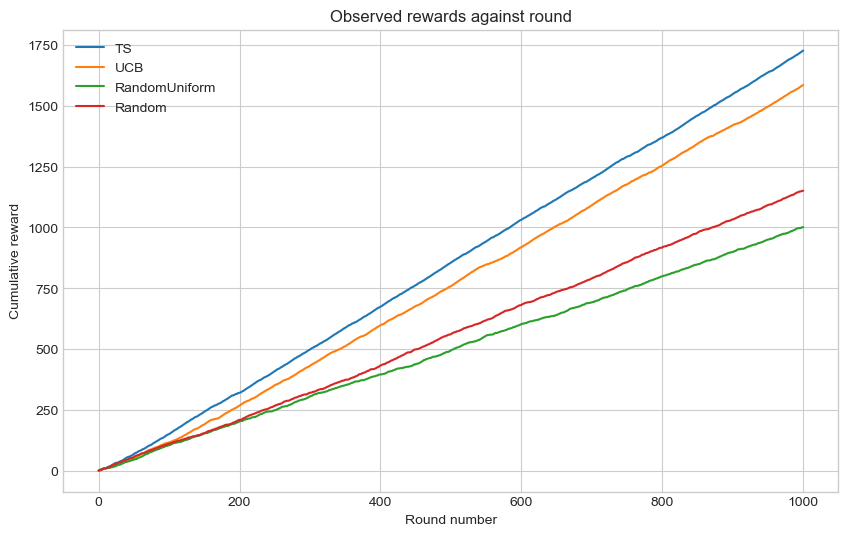

In [ ]:
# create many arms
n_arms = 10
arms = [bandits.BernoulliArm() for _idx in range(n_arms)]
print(arms)

# create multiple policies
policies = {
    "TS": bandits.ThompsonSamplingBeta(n_arms=n_arms, top_k=2),
    "UCB": bandits.UCB(n_arms=n_arms, top_k=2),
    "RandomUniform": bandits.RandomPolicy(n_arms=n_arms, top_k=2),
    "Random": bandits.RandomPolicy(n_arms=n_arms, top_k=2, reward_probs=np.array([0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])),
}

simulation_results = {
    _name: bandits.simulate_batches(
        policy=_policy, arms=arms, n_batches=100, batch_size=10, return_regret=False
    )
    for _name, _policy in policies.items()
}

fig_sel, ax_sel = plt.subplots(figsize=(12, 6), ncols=len(simulation_results))
fig_rew, ax_rew = plt.subplots(figsize=(10, 6))
for _idx, (_name, _simulation_results) in enumerate(simulation_results.items()):
    bandits.plot_arm_selection(
        selected_arms=_simulation_results["selected_arms"], ax=ax_sel[_idx]
    )
    ax_sel[_idx].set_title(ax_sel[_idx].get_title() + " - " + _name)
    bandits.plot_rewards(rewards=_simulation_results["rewards"], ax=ax_rew, label=_name)
ax_rew.legend()

fig_sel.show()
fig_rew.show()